In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import glob

In [2]:
import matplotlib
def brown_green():
    '''
    returns a colormap based on colorbrewer diverging brown->green
    '''

    # colorbrewer colormap, diverging, brown->green
    cmap = np.zeros([11,3]);
    cmap[0,:] = 84,48,5
    cmap[1,:] = 140,81,10
    cmap[2,:] = 191,129,45
    cmap[3,:] = 223,194,125
    cmap[4,:] = 246,232,195
    cmap[5,:] = 245,245,245
    cmap[6,:] = 199,234,229
    cmap[7,:] = 128,205,193
    cmap[8,:] = 53,151,143
    cmap[9,:] = 1,102,94
    cmap[10,:] = 0,60,48
    cmap = matplotlib.colors.ListedColormap(cmap/256)
    
    return cmap

In [3]:
import statsmodels.api as sm

In [4]:
from utils import *

In [5]:
from scipy import stats

In [7]:
d='/glade/scratch/djk2120/postp/'
files=sorted(glob.glob(d+'*.nc'))
la=xr.open_dataset('mask_grnlnd_antarc.nc').landarea
yy=slice(1976,1990)
ss={}
rs={}
ps={}
mgrid={}

In [9]:
cf=24*60*60*365

In [10]:
for f in files:

    ds=xr.open_dataset(f)
    mem=str(ds.mem.values)
    print(mem)
    nbpa=detrend_dim(cf*ds.NBP.sel(year=yy),'year')
    twsa=detrend_dim(ds.TWS.sel(year=yy),'year')
    ix=(la>0)&(twsa.std(dim='year')>0)
    ivals=np.tile(np.arange(192).reshape([-1,1]),[1,288])[ix]
    jvals=np.tile(np.arange(288),[192,1])[ix]
    slopes=np.zeros([192,288])+np.nan
    rvals=np.zeros([192,288])+np.nan
    pvals=np.zeros([192,288])+np.nan
    for i,j in zip(ivals,jvals):
        x=twsa[:,i,j]
        y=nbpa[:,i,j]
        m,b,r,p,err=stats.linregress(x,y)
        slopes[i,j]=m
        rvals[i,j]=r
        pvals[i,j]=p

    ss[mem]=slopes
    rs[mem]=rvals
    ps[mem]=pvals
    twsvar=(la*twsa).var(dim='year').values
    wts=twsvar[pvals<0.05]
    wts=wts/wts.sum()
    mgrid[mem]=(wts*slopes[pvals<0.05]).sum()

In [15]:
g=xr.open_dataset('/glade/u/home/djk2120/TWSnbp/postp/cesm2.globann.nc')

In [22]:
nbpa=detrend_dim(cf*g.NBP.sel(year=yy),'year')
twsa=detrend_dim(g.TWS.sel(year=yy),'year')
mvals=[]
for i in g.ens:
    x=twsa.sel(ens=i)
    y=nbpa.sel(ens=i)
    m,b,r,p,err=stats.linregress(x,y)
    mvals.append(m)

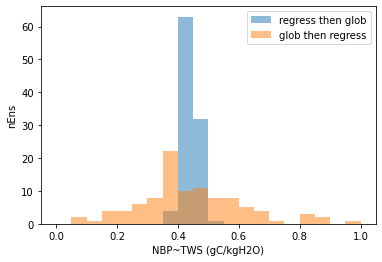

In [30]:
plt.hist([mgrid[m] for m in mgrid],np.arange(21)/20,alpha=0.5,label='regress then glob')
plt.hist(mvals,np.arange(21)/20,alpha=0.5,label='glob then regress')
plt.legend();
plt.xlabel('NBP~TWS (gC/kgH2O)')
plt.ylabel('nEns');

In [31]:
whit=xr.open_dataset('whitfull.nc')

In [38]:
def pp(ds):
    return ds[['TWS','NBP']].sel(year=yy)

In [39]:
ds=xr.open_mfdataset(files,concat_dim='mem',combine='nested',
                     preprocess=pp)

In [47]:
nbp=cf*xr.concat([gmean(ds.NBP,la),gmean(ds.NBP,la,whit.biome)],dim='biome')
tws=xr.concat([gmean(ds.TWS,la),gmean(ds.TWS,la,whit.biome)],dim='biome')

In [48]:
nbpa=detrend_dim(nbp,'year')
twsa=detrend_dim(tws,'year')

In [54]:
mbiome={}
rbiome={}
for b in range(11):
    mbs=[]
    rbs=[]
    for m in range(100):
        x=nbpa.isel(biome=b,mem=m)
        y=twsa.isel(biome=b,mem=m)
        m,x,r,p,err=stats.linregress(x,y)
        mbs.append(m)
        rbs.append(r)
    
    if b>0:
        biome=str(whit.biome_name.sel(biome_id=nbpa.biome[b]).values)
    else:
        biome=str(nbpa.biome[b].values)
    mbiome[biome]=mbs
    rbiome[biome]=rbs
        

In [84]:
twsvarbiome=(la.groupby(whit.biome).sum()*twsa.stack({'memyear':['mem','year']})).var(dim='memyear')
twsvarbiome=100*twsvarbiome/twsvarbiome.sum()

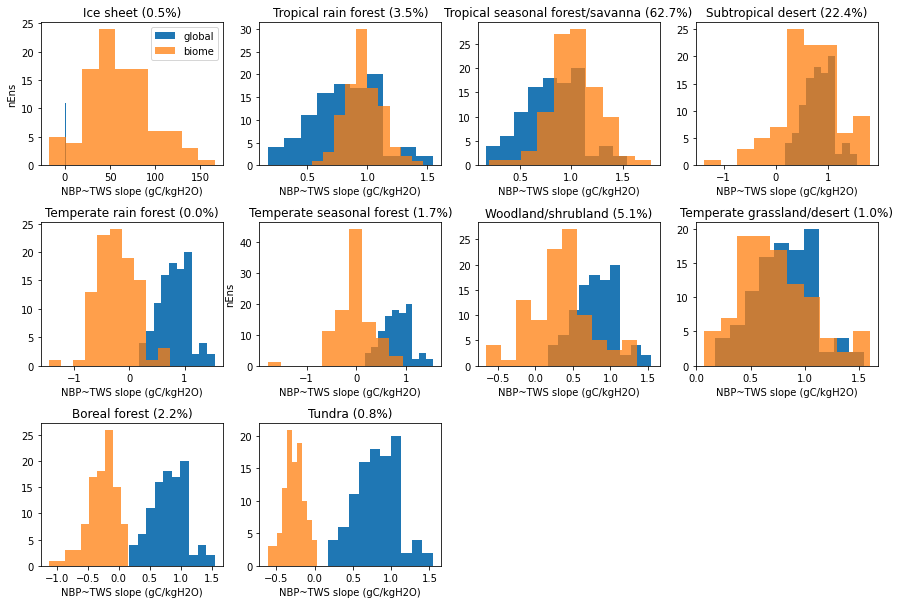

In [159]:
plt.figure(figsize=[15,10])
for i,b in enumerate(whit.biome_name.values):
    plt.subplot(3,4,i+1)
    plt.hist(mbiome['global'],label='global')
    plt.hist(mbiome[b],alpha=0.75,label='biome')
    plt.title(b+' ('+str(np.round(twsvarbiome.isel(biome=i).values,1))+'%)')

    plt.xlabel('NBP~TWS slope (gC/kgH2O)')
    if i%5==0:
        plt.ylabel('nEns')
    if i==0:
        plt.legend(loc=1)
    
plt.subplots_adjust(hspace=0.4)

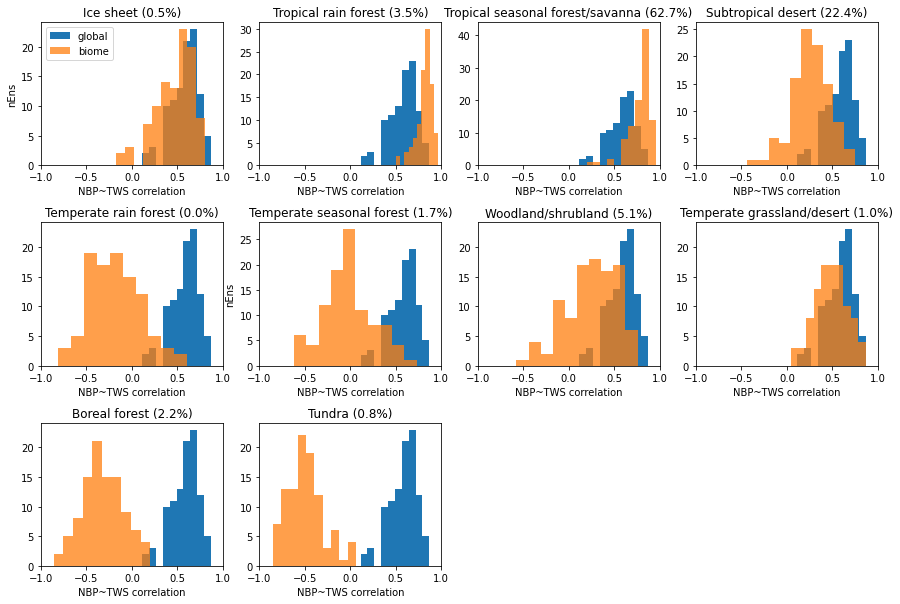

In [162]:
plt.figure(figsize=[15,10])
for i,b in enumerate(whit.biome_name.values):
    plt.subplot(3,4,i+1)
    plt.hist(rbiome['global'],label='global')
    plt.hist(rbiome[b],alpha=0.75,label='biome')
    plt.title(b+' ('+str(np.round(twsvarbiome.isel(biome=i).values,1))+'%)')

    plt.xlabel('NBP~TWS correlation')
    plt.xlim([-1,1])
    if i%5==0:
        plt.ylabel('nEns')
    if i==0:
        plt.legend(loc=2)
    
plt.subplots_adjust(hspace=0.4)

In [104]:
pprob=np.zeros(la.shape)
for mem in ps:
    pprob=pprob+1/len(ps)*(ps[mem]<0.05)
    

In [113]:
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

In [153]:
cmap = plt.cm.viridis
cmaplist = [cmap(i) for i in np.linspace(0,255,8).astype(int)]
vd=matplotlib.colors.ListedColormap(cmaplist)

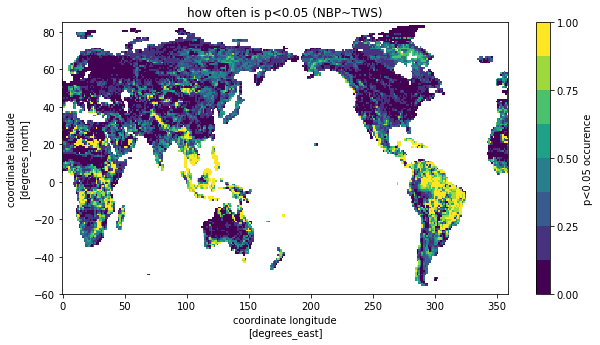

In [156]:
plt.figure(figsize=[10,5])
kwargs={'label':'p<0.05 occurence','ticks':np.arange(5)/4}
xr.DataArray(pprob,coords=la.coords).where(la>0).plot(cmap=vd,
                                                      cbar_kwargs=kwargs);
plt.ylim([-60,85])
plt.title('how often is p<0.05 (NBP~TWS)');

In [244]:
ix=(la>0)&(ds.NEP.mean(dim=['ens','year'])>0)

In [263]:
tsa=ds.TSA.mean(dim=['ens','year']).compute()
prec=ds.PREC.mean(dim=['ens','year']).compute()

In [282]:
tvals=265+np.arange(16)*2.5
pvals=100*np.arange(31)
s=np.zeros([30,15])+np.nan
for i in range(30):
    for j in range(15):
        ixt=(tsa>=tvals[j])&(tsa<tvals[j+1])
        ixp=(prec>=pvals[i])&(prec<pvals[i+1])
        ixtp=(ixt)&(ixp)
        if ix.values[ixtp].sum()>15:
            s[i,j]=np.nanmean(slopes[ixtp])

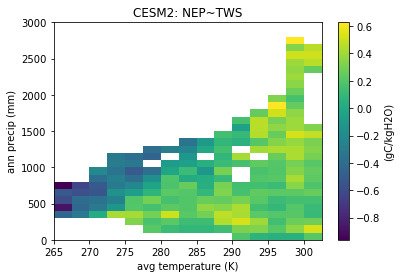

In [288]:
plt.pcolormesh(tvals,pvals,s)
plt.colorbar(label='(gC/kgH2O)')
plt.xlabel('avg temperature (K)')
plt.ylabel('ann precip (mm)')
plt.title('CESM2: NEP~TWS');